In [93]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [5]:
matches = pd.read_csv('data/seasons_merged.csv')
letter_to_result = {'H': 1, 'D': 0, 'A': -1}

matches

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HY,AY,HR,AR,B365H,B365D,B365A,BbAvH,BbAvD,BbAvA
0,0,2009-08-15,Aston Villa,Wigan,0,2,-1,0,1,A,...,2,2,0,0,1.67,3.60,5.50,1.66,3.51,5.33
1,1,2009-08-15,Blackburn,Man City,0,2,-1,0,1,A,...,2,1,0,0,3.60,3.25,2.10,3.37,3.24,2.12
2,2,2009-08-15,Bolton,Sunderland,0,1,-1,0,1,A,...,2,1,0,0,2.25,3.25,3.25,2.24,3.20,3.15
3,3,2009-08-15,Chelsea,Hull,2,1,1,1,1,D,...,1,2,0,0,1.17,6.50,21.00,1.17,6.26,16.39
4,4,2009-08-15,Everton,Arsenal,1,6,-1,0,3,A,...,0,0,0,0,3.20,3.25,2.30,3.07,3.21,2.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,3795,2019-12-05,Liverpool,Wolves,2,0,1,1,0,H,...,0,2,0,0,1.30,6.00,11.00,1.30,5.62,10.17
3796,3796,2019-12-05,Man United,Cardiff,0,2,-1,0,1,A,...,3,3,0,0,1.28,6.50,11.00,1.28,6.18,10.10
3797,3797,2019-12-05,Southampton,Huddersfield,1,1,0,1,0,H,...,0,1,0,0,1.44,4.75,8.50,1.42,4.81,7.64
3798,3798,2019-12-05,Tottenham,Everton,2,2,0,1,0,H,...,0,2,0,0,2.20,3.50,3.50,2.09,3.51,3.58


In [6]:
def coefficients_to_probability(matches):
    '''
    Converts betting platform coefficient(1 < x) with % of income
    into a probability coefficient(0 < x < 1)
    '''
    # How many profit betting companies make on bets
    matches['profit_B365'] = sum((1/matches['B365H'], 1/matches['B365D'], 1/matches['B365A']))
    matches['profit_BbAv'] = sum((1/matches['BbAvA'], 1/matches['BbAvD'], 1/matches['BbAvH']))

    # Converting all betting coefficients into probabilities of homw/draw/away:
    for betting_column in ['B365H', 'B365D', 'B365A', 'BbAvH', 'BbAvD', 'BbAvA']:
        matches[betting_column] = 1 / (matches[betting_column] * matches['profit_' + betting_column[:-1]])

    return matches


def get_home_wins(matches):
    """ (pandas Dataframe)-> int
    Returns a total number of times, the home team has won 
    """
    home = matches.loc[matches['FTR'] == 1]
    return home.shape[0]
coefficients_to_probability(matches)


def get_away_wins(seasons_merged):
    """ (pandas Dataframe)-> int
    Returns a total number of times, the away team has won
    """
    away = matches.loc[seasons_merged['FTR'] == -1]
    return away.shape[0]

0.29 0.4626315789473684


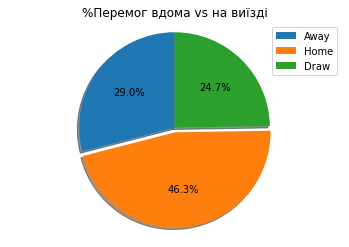

In [7]:
def draw_home_away_wins(matches):
    """
    Reads a dataset and draws a pie chart with the percentage of
    home, away and draw results
    """
    num_matches = matches.shape[0]
    away_percentage = get_away_wins(matches) / num_matches
    home_percentage = get_home_wins(matches) / num_matches
    draw_percentage = 1 - away_percentage - home_percentage
    print(away_percentage, home_percentage)

    # Creating the pie chart
    sizes = [away_percentage, home_percentage, draw_percentage]
    explode = (0, 0.05, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('%Перемог вдома vs на виїзді')
    plt.labels = 'Away', 'Home', 'Draw'
    plt.legend(plt.labels)
    plt.show()

draw_home_away_wins(matches)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98c36710d0>,
      dtype=object)

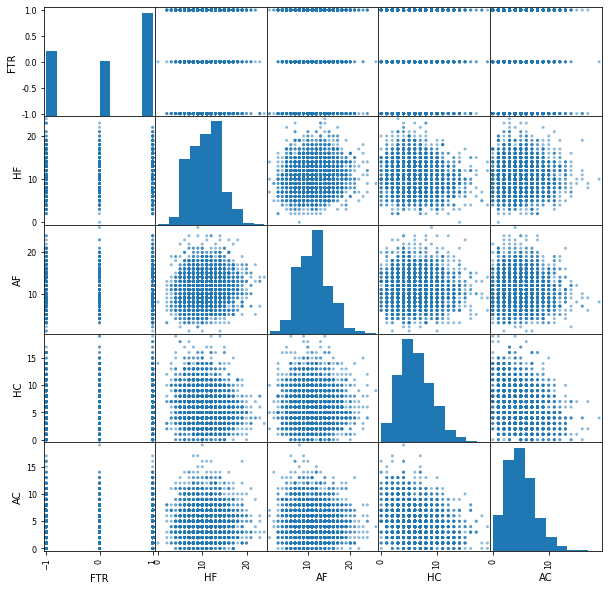

In [8]:
# Як можна побачити, домашня команда має значно більший шанс перемогти, і це
# буде одним з визначальних критеріїв в майбутній моделі
from pandas.plotting import scatter_matrix
matches.columns
# , 'HY', 'AY', 'HR', 'AR'
# , 'HF', 'AF', 'HC', 'AC'
# scatter_matrix(matches[['FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST']], figsize=(10,10))
scatter_matrix(matches[['FTR', 'HF', 'AF', 'HC', 'AC']], figsize=(10,10))


In [24]:
def get_n_last_matches(matches, date, team, n = 10):
    '''
    Get the last n matches of a given team.
    '''
    # All matches with a given team
    team_matches = matches[(matches['HomeTeam'] == team) | (matches['AwayTeam'] == team)]
    
    #Filter n last matches from team matches
    n_last_matches = (team_matches[team_matches.Date < date]
                      .sort_values(by = 'Date', ascending = False)
                      .iloc[0:n,:])
    
    return n_last_matches


def get_n_last_matches_against_each_other(matches, date, home_team, away_team, n = 5):
    ''' 
    Get the last n matches of two given teams.
    '''
    
    home_matches = matches[(matches['HomeTeam'] == home_team) & (matches['AwayTeam'] == away_team)]    
    away_matches = matches[(matches['HomeTeam'] == away_team) & (matches['AwayTeam'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    # Get last n matches, if possible:
    try:    
        last_matches = (total_matches[total_matches.Date < date]
                        .sort_values(by = 'Date', ascending = False)
                        .iloc[0:n,:])
    except:  # If there are less than n matches
        last_matches = (total_matches[total_matches.Date < date]
                        .sort_values(by = 'Date', ascending = False)
                        .iloc[0:total_matches.shape[0],:])

    return last_matches


def get_goals(matches, team):
    '''
    Get total number of goals,a specfic team has scored 
    from a dataframe of specific matches
    '''
    home_goals = matches.FTHG[matches.HomeTeam == team].sum()
    away_goals = matches.FTAG[matches.AwayTeam == team].sum()

    return home_goals + away_goals

def get_concealed_goals(matches, team):
    '''
    Get all the goals, concealed of a specfic team from a dataframe of specific matches
    '''
    home_goals = matches.FTAG[matches.HomeTeam == team].sum()
    away_goals = matches.FTHG[matches.AwayTeam == team].sum()

    return home_goals + away_goals

def get_wins(matches, team):
    '''
    Get the number of wins of a specfic team from a dataframe of specific matches.
    '''
    home_wins = matches[(matches.FTR == 1) & (matches.HomeTeam == team)].shape[0]
    away_wins = matches[(matches.FTR == -1) & (matches.AwayTeam == team)].shape[0]

    return home_wins + away_wins

# get_wins(get_n_last_matches_against_each_other(matches, '2020-12-15', 'Liverpool', 'Tottenham', 10), 'Liverpool')
# get_n_last_matches_against_each_other(matches, '2020-12-15', 'Liverpool', 'Tottenham', 10)


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HR,AR,B365H,B365D,B365A,BbAvH,BbAvD,BbAvA,profit_B365,profit_BbAv
3732,3732,2019-03-31,Liverpool,Tottenham,2,1,1,1,0,H,...,0,0,0.605449,0.232089,0.162462,0.596549,0.232553,0.170898,1.025880,1.041185
3465,3465,2018-09-15,Tottenham,Liverpool,1,2,-1,0,1,A,...,0,0,0.324324,0.270270,0.405405,0.323089,0.265076,0.411835,1.027778,1.042128
3298,3298,2018-04-02,Liverpool,Tottenham,2,2,0,1,0,H,...,0,0,0.466563,0.261275,0.272162,0.461183,0.259962,0.278855,1.020635,1.042470
2901,2901,2017-11-02,Liverpool,Tottenham,2,0,1,2,0,H,...,0,0,0.425000,0.287500,0.287500,0.429636,0.288139,0.282224,1.023018,1.039085
3129,3129,2017-10-22,Tottenham,Liverpool,4,1,1,3,1,H,...,0,0,0.433543,0.278706,0.287750,0.438008,0.274384,0.287608,1.025144,1.047277
2686,2686,2016-08-27,Tottenham,Liverpool,1,1,0,0,1,A,...,0,0,0.401070,0.280749,0.318182,0.403496,0.278801,0.317703,1.047619,1.045712
2586,2586,2016-02-04,Liverpool,Tottenham,1,1,0,0,0,D,...,0,0,0.389313,0.286260,0.324427,0.386351,0.285715,0.327934,1.027451,1.047902
2365,2365,2015-10-17,Tottenham,Liverpool,0,0,0,0,0,D,...,0,0,0.392523,0.280374,0.327103,0.392194,0.280303,0.327502,1.019048,1.049283
2142,2142,2015-10-02,Liverpool,Tottenham,3,2,1,1,1,D,...,0,0,0.510883,0.256786,0.232330,0.507906,0.260892,0.231202,1.024813,1.047270
1929,1929,2014-08-31,Tottenham,Liverpool,0,3,-1,0,1,A,...,0,0,0.360825,0.278351,0.360825,0.362391,0.281979,0.355630,1.026455,1.049220


In [107]:
def get_features_for_match(match, matches, n1=10, n2=3):
    '''
    Creates a special set of features for each match, if possible(10 last matches
    and 3 last matches against each other)
    '''
    match_date = match.Date
    home_team = match.HomeTeam
    away_team = match.AwayTeam
    # Get n1 last matches of 2 teams
    home_last = get_n_last_matches(matches, match_date, home_team, n=n1)
    away_last = get_n_last_matches(matches, match_date, away_team, n=n1)
    # Get last n2 matches against each other
    home_last_against = get_n_last_matches_against_each_other(matches, match_date, home_team, away_team, n=n2)
    away_last_against = get_n_last_matches_against_each_other(matches, match_date, away_team, home_team, n=n2)
    # Goals stuff
    home_goals = get_goals(home_last, home_team)
    away_goals = get_goals(away_last, away_team)
    home_goals_conceided = get_concealed_goals(home_last, home_team)
    away_goals_conceided = get_concealed_goals(away_last, away_team)
    #Define result data frame
#     print(home_goals, home_goals_conceided)
    result = pd.DataFrame()
    result.loc[0, 'H_goal_diff'] = home_goals - home_goals_conceided
    result.loc[0, 'A_goal_diff'] = away_goals - away_goals_conceided
    result.loc[0, 'H_win'] = get_wins(home_last, home_team) 
    result.loc[0, 'A_win'] = get_wins(away_last, away_team)
    result.loc[0, 'H_win_against'] = get_wins(home_last_against, home_team)
    result.loc[0, 'A_win_against'] = get_wins(away_last_against, away_team)
    # TODO ПОПРООБУВАТИ ЩЕ ЯКІСЬ КРИТЕРІЇ
#     print(result.loc[0])
    return result.loc[0]


def create_features(matches):
    '''
    Iterate throu all matches, create features for every single of them
    if possible and aggregate them together
    '''
    # Creates dataframe with features for all matches
    matches_features = matches.apply(lambda x: get_features_for_match(x, matches, n1=12, n2=3), axis=1)
#     return matches
    print('overall time is', time.time() - time_start)

    return matches_features
# get_features_for_match(matches.iloc[-1:], matches, n1=10, n2=3)
time_start = time.time()
features = create_features(matches)
features2 = features.copy()

overall time is 175.38670086860657


In [106]:
# Merging feaures with match data and write it into a file
# features = pd.merge(matches, features, left_index=True, right_index=True)
features
# features.to_csv('data/features.csv')

,Unnamed: 0_x,Date_x,HomeTeam_x,AwayTeam_x,FTHG_x,FTAG_x,FTR_x,HTHG_x,HTAG_x,HTR_x,...,BbAvD_y,BbAvA_y,profit_B365_y,profit_BbAv_y,H_goal_diff,A_goal_diff,H_win,A_win,H_win_against,A_win_against
0,0,2009-08-15,Aston Villa,Wigan,0,2,-1,0,1,A,...,0.265041,0.174540,1.058398,1.074927,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2009-08-15,Blackburn,Man City,0,2,-1,0,1,A,...,0.286555,0.437943,1.061661,1.077076,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2009-08-15,Bolton,Sunderland,0,1,-1,0,1,A,...,0.290323,0.294931,1.059829,1.076389,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2009-08-15,Chelsea,Hull,2,1,1,1,1,D,...,0.148536,0.056732,1.056166,1.075458,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2009-08-15,Everton,Arsenal,1,6,-1,0,3,A,...,0.289562,0.407672,1.054975,1.075856,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,3795,2019-12-05,Liverpool,Wolves,2,0,1,1,0,H,...,0.170193,0.094050,1.026807,1.045495,20.0,2.0,10.0,5.0,3.0,0.0
3796,3796,2019-12-05,Man United,Cardiff,0,2,-1,0,1,A,...,0.155279,0.095013,1.026005,1.042072,-1.0,-11.0,5.0,3.0,2.0,0.0
3797,3797,2019-12-05,Southampton,Huddersfield,1,1,0,1,0,H,...,0.199326,0.125492,1.022618,1.043016,-3.0,-20.0,5.0,1.0,1.0,0.0
3798,3798,2019-12-05,Tottenham,Everton,2,2,0,1,0,H,...,0.273234,0.267891,1.025974,1.042699,1.0,8.0,4.0,6.0,3.0,0.0
